In [1]:
#%matplotlib widget 
import numpy as np
import time
from datetime import datetime, timedelta
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from pyproj import Transformer, CRS
from shapely.geometry import Polygon, Point
from sliderule import sliderule
from sliderule import icesat2
from pyproj import Transformer, CRS
import logging
import requests
import os
import ipyleaflet
from ipyleaflet import Map, GeoData, LayersControl,Rectangle, basemaps, basemap_to_tiles, TileLayer, SplitMapControl, Polygon
from mpl_toolkits import mplot3d
import rasterio
from rasterio.plot import show
from rasterio.transform import Affine

In [2]:
url="icesat2sliderule.org"
icesat2.init(url, verbose=True, loglevel=logging.DEBUG)
asset = "nsidc-s3"

ConnectTimeout: HTTPConnectionPool(host='icesat2sliderule.org', port=80): Max retries exceeded with url: /discovery/ (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0x7f91386a7850>, 'Connection to icesat2sliderule.org timed out. (connect timeout=10)'))

## Introduction
This notebook explores various ways of visualizing/manipulating/potentially rasterizing ATL03 data, with an emphasis on Arctic and Alaskan Coastal environments. NO CLAIMS ARE MADE ABOUT THE GEOLOCATION ACCURACY OF THE DATA, OR QUALITY OF THE CODE/METHODS.

__To-Do__
- Separate out strong/weak beams
- Test YAPC and other signal instead of ATL03 land confidence (signal_conf_ph 3+)
- Better account for CRS/Projections
- Set realistic horizontal and vertical binning resolutions
- Properly scale density values (set very high currently for viz/debugging)
- Make sure non-square geotiffs don't break indexing
- Figure out solution for writing cloud optimized geotiffs?
- Improve speed of rasterizing/histogramming
- Add no-data masks to geotiff

__Author__: Jonathan Markel (jonathanmarkel@utexas.edu) March 23, 2022

### Set query/download parameters
Let's start with a bounding box GeoJSON and a time window, downloading all ICESat-2 ATL03 signal that matches our query.

In [ ]:
# Find granules for the region of interest
geo_bb = 'white_mountain.geojson'

# Convert to Alaska polar stereo and EGM08 referenced heights
#target_srs = "EPSG:5396+EPSG:3855" # not sure I'm doing this right later?

# Convert white mountain bounding box to happy sliderule version polygon
reg = icesat2.toregion(geo_bb) 
poly = reg['poly']

# interactive plot from Eli/Erin example
bb = [poly[0]['lon'], poly[0]['lat'], 
      poly[2]['lon'], poly[2]['lat']]

# create polygon for plotting
polygon = Polygon(
    locations=poly,
    color="green"
)

# quick visualization - requires running the cell
center = [poly[0]['lat'], poly[0]['lon']]
zoom = 8
m = Map(basemap=basemaps.Esri.WorldImagery, center=center, zoom=zoom)
m.add_layer(polygon);
m

In [5]:
# Start time and end time for granule filtering
time_start = "2019-04-01T00:00:00Z"
time_end = "2019-05-31T00:00:00Z"

granules_list = icesat2.cmr(polygon=poly, version='005', short_name='ATL03', 
                            time_start=time_start, 
                            time_end=time_end)
granules_list

['ATL03_20190404175540_00990303_005_01.h5',
 'ATL03_20190410060634_01830305_005_01.h5',
 'ATL03_20190414055813_02440305_005_01.h5',
 'ATL03_20190418054952_03050305_005_01.h5',
 'ATL03_20190503163138_05410303_005_01.h5',
 'ATL03_20190507162318_06020303_005_01.h5',
 'ATL03_20190513043412_06860305_005_01.h5']

In [7]:
params = {}

# Beam pair parameter - 0 default for all 3 reference beams
track = 0

# Reference ground track - default to all if not specified
rgt = None

# ICESat2 cycle 91 days
cycle = None

# Geographic region 1-14
region = None

# Compile parameters
params['poly'] = poly
#params['track'] = track
#params['rgt'] = rgt
#params['cycle'] = cycle
#params['region'] = region
#params['t0'] = t0
#params['t1'] = t1

# for now, lets just get med-high confidence land photons
params['srt'] = 0
params['cnf'] = 3

#params['len'] = 20. # AT distance to consider groups
#params['cnt'] = 10. # only return photons from AT len groups with at least this many photons
#params['pass_invalid'] = True

# ICESat-2 data release
release = '005'

### Submitting Sliderule Request
Now we will use the parameters specified above to submit our Sliderule request

In [8]:
gdf = icesat2.atl03sp(params, asset=asset, version=release, resources=granules_list)
gdf.head()

INFO:sliderule.icesat2:Allocating 21 workers across 7 processing nodes
INFO:sliderule.icesat2:0 points returned for ATL03_20190507162318_06020303_005_01.h5 (1 out of 7 resources)
INFO:sliderule.icesat2:0 points returned for ATL03_20190410060634_01830305_005_01.h5 (2 out of 7 resources)
INFO:sliderule.icesat2:0 points returned for ATL03_20190418054952_03050305_005_01.h5 (3 out of 7 resources)
INFO:sliderule.icesat2:0 points returned for ATL03_20190503163138_05410303_005_01.h5 (4 out of 7 resources)
INFO:sliderule.icesat2:116904 points returned for ATL03_20190513043412_06860305_005_01.h5 (5 out of 7 resources)
INFO:sliderule.icesat2:1861104 points returned for ATL03_20190414055813_02440305_005_01.h5 (6 out of 7 resources)
INFO:sliderule.icesat2:2747050 points returned for ATL03_20190404175540_00990303_005_01.h5 (7 out of 7 resources)


,sc_orient,segment_dist,cycle,rgt,track,segment_id,delta_time,atl08_class,height,yapc_score,quality_ph,distance,atl03_cnf,pair,geometry
time,,,,,,,,,,,,,,,
2019-04-04 17:56:58.053514368,0,7.179080e+06,3,99,3,358130,3.963582e+07,4,7.142245,0,0,-17.148812,4,0,POINT (-163.13100 64.40141)
2019-04-04 17:56:58.053514368,0,7.179080e+06,3,99,3,358130,3.963582e+07,4,7.004031,0,0,-17.148048,4,0,POINT (-163.13100 64.40141)
2019-04-04 17:56:58.053614368,0,7.179080e+06,3,99,3,358130,3.963582e+07,4,6.998898,0,0,-16.438267,4,0,POINT (-163.13100 64.40142)
2019-04-04 17:56:58.053614368,0,7.179080e+06,3,99,3,358130,3.963582e+07,4,6.990474,0,0,-16.438267,4,0,POINT (-163.13100 64.40142)
2019-04-04 17:56:58.053614368,0,7.179080e+06,3,99,3,358130,3.963582e+07,4,6.993803,0,0,-16.438267,4,0,POINT (-163.13100 64.40142)


In [9]:
# remnant of testing different crs'
data = gdf #.to_crs(target_srs)

In [10]:
# Read geojson with geopandas to plot alongside IS2 tracks
pregion = gpd.read_file(geo_bb)#.to_crs(target_srs)

<AxesSubplot:>

<Figure size 576x432 with 0 Axes>

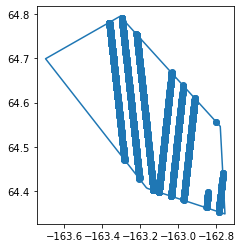

In [11]:
plt.figure(figsize=[8,6])

# Plot bounding box
f1 = pregion.boundary.plot()

# Subsample photon data to reduce plotting chaos/memory load
data.sample(10000).geometry.plot(ax=f1)

In [12]:
# Get plane data within a vertical bin
v_bin = [0, 30] # bin ~30 meters above ~water to test viz
data_plane = data.iloc[(data.height.values > v_bin[0]) & (data.height.values < v_bin[1])]

Lets start with the case of rasterizing just one 'band' of ICESat-2 data, where the band consists of signal density in the range of 0-30m.

In [15]:
# Define square grid to encapsulate entire bounding box
x_plane = data_plane.geometry.x.values
y_plane = data_plane.geometry.y.values
# Multiple bands shouldnt have dynamically chan

# Define horizontal bins (along/across track probably .5mx.5m)
xbinedges = np.linspace(min(x_plane), max(x_plane), 100)
ybinedges = np.linspace(min(y_plane), max(y_plane), 100)

# Calculate rough histogram
hist = np.histogram2d(data_plane.geometry.x.values, data_plane.geometry.y.values, [xbinedges, ybinedges])

Text(291.03880775244534, 0.5, 'Latitude')

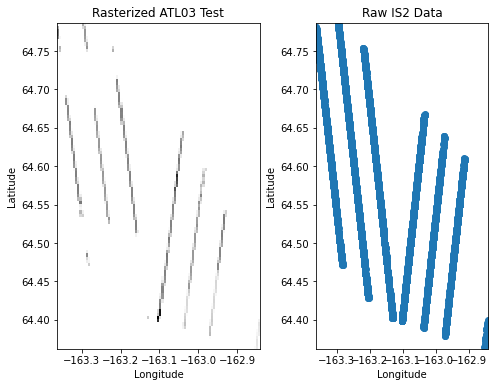

In [17]:
plt.figure(figsize=[8,6])
ax1 = plt.subplot(121)
hist, _, _, fig = plt.hist2d(data_plane.geometry.x.values, data_plane.geometry.y.values, [xbinedges, ybinedges], cmap='binary')
plt.title('Rasterized ATL03 Test')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

ax2 = plt.subplot(122, sharex=ax1, sharey=ax1)
data.sample(10000).geometry.plot(ax=ax2)
plt.title('Raw IS2 Data')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

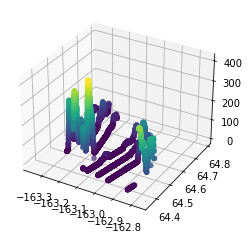

In [19]:
# Plot 3D data to get a sense of topography and scale
# enable %matplotlib widget at top and rerun to make interactive

fig = plt.figure()
ax = plt.axes(projection='3d')
ds = data.sample(10000)
xdata = ds.geometry.x
ydata = ds.geometry.y
zdata = ds.height
ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='viridis');

In [27]:
len(vbins)

3

In [32]:
# convert sliced icesat2 data into multi band geotiff
# using part of https://stackoverflow.com/questions/33537599/how-do-i-write-create-a-geotiff-rgb-image-file-in-python

# this scene looks to have some elevation change (0 - 300+ m), so we'll choose according vertical bin sizes to test with
vbins = [(-50, 50), (50, 200), (200, 1000)]
n = len(vbins)

# define the x, y resolution at which to rasterize the icesat2 data
# using square for now for quick testing - not checked for non-square arrays
x_im = 400
y_im = x_im

image_size = (n, x_im, y_im)

# use the max limits of the input bounding box to define the bounds of the resulting image
# print('Overall bounding box of input geojson', reg['raster']['bbox'])

lat = [reg['raster']['bbox'][1], reg['raster']['bbox'][3]]
lon = [reg['raster']['bbox'][0],reg['raster']['bbox'][2]]

#  preallocating channel array
pixels = np.zeros((image_size), dtype=np.uint8)

# defining edges of histogramming bins
xbinedges = np.linspace(lon[0], lon[1], x_im+1)
ybinedges = np.linspace(lat[0], lat[1], y_im+1)

# look at each slice (vertical bin) of the icesat2 data
for i in range(n):
    
    # Get data within a vertical bin
    bin_bot = vbins[i][0]
    bin_top = vbins[i][1]
    #print(bin_bot, bin_top)
    data_plane = data.iloc[(data.height.values > bin_bot) & (data.height.values < bin_top)]
    
    # count up how many photons fall in each lat/lon bucket
    # hmm, this is not a particularly fast function here even with coarse values...
    hist_i = np.histogram2d(data_plane.geometry.x.values, data_plane.geometry.y.values, [xbinedges, ybinedges])
    
    # RESCALING IMAGE INTENSITY FOR EASIER VISUALIZATION/DEBUGGING
    # REMOVE THIS STEP IN LATER ANALYSIS
    pixels[i, :, :] = hist_i[0] / hist_i[0].max() * 255
    
    #pixels[i, :, :] = hist_i[0]
    

#### Writing multi-'band' geotiff

Note: GDAL drivers for __cloud optimized geotiffs__ dont support writing.

In [33]:
# using rasterio
# https://rasterio.readthedocs.io/en/latest/quickstart.html#creating-data

output_raster_filename = 'sample_is2_multiband_raster.tif'

# coordinate transformation
# verify this is right with better GIS folks and coffee
res = (lon[1] - lon[0]) / x_im
transform = Affine.translation(lon[0] - res / 2, lat[0] - res / 2) * Affine.scale(res, res)

# writing geotiff file
Z = np.transpose(pixels[:, :, :], [0, 2, 1])
with rasterio.open(
    output_raster_filename,
    'w',
    driver='GTiff',
    height=Z.shape[1],
    width=Z.shape[2],
    count=Z.shape[0],
    dtype=Z.dtype,
    crs="+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs",
    transform=transform) as dst:
    dst.write(Z)

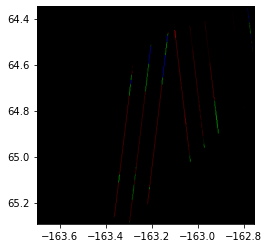

<AxesSubplot:>

In [34]:
# Check that rasterio is able to open the file and that referencing looks right

fp = r'sample_is2_multiband_raster.tif'
src = rasterio.open(fp)
show(src)
# note inverted latitude because of how matplotlib plots 2d arrays starting in upper left corner

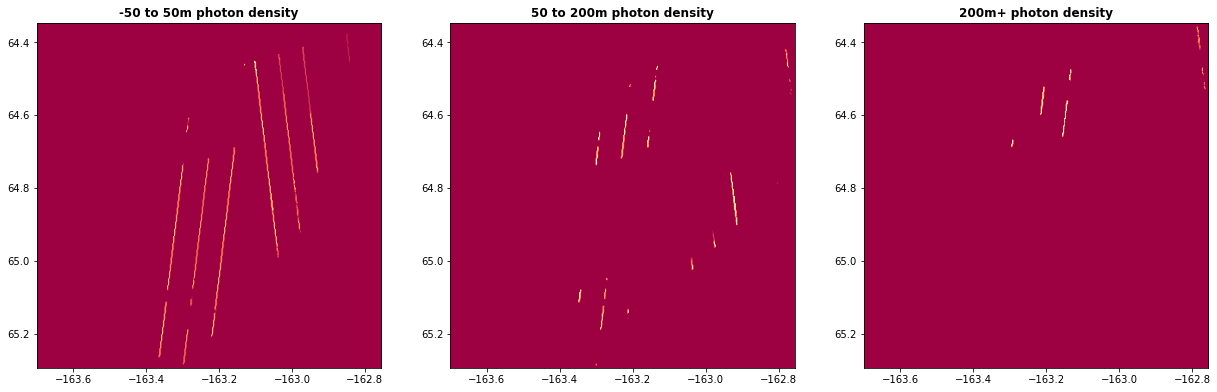

In [36]:
# Compare each of the bands stored in the geotiff file

fig, (axr, axg, axb) = plt.subplots(1,3, figsize=(21,7))
show((src, 1), ax=axr, cmap='Spectral', title='-50 to 50m photon density')
show((src, 2), ax=axg, cmap='Spectral', title='50 to 200m photon density')
show((src, 3), ax=axb, cmap='Spectral', title='200m+ photon density')
plt.show()